<a href="https://colab.research.google.com/github/nikalitt1/Clementine-Agriculture/blob/main/Juniper_Setup/clementine_ag_Juniper_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

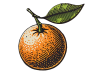

# Clementine Agriculture Tutorial: Training, deployment and setup of scripts for the Juniper and other modules

Welcome!

This tutorial will include:
* Setting up Jetson Orin Nano for deploymeny in Clementine Ag products
*Scripts for product operation, training, and datacollection


First, run the following commands on the Jetson orin nano after initial boot into Jetpack 6.2 in order have all the packages run properly. These setup commands can be found in the following links as well:

* https://docs.ultralytics.com/guides/nvidia-jetson/#install-ultralytics-package
* https://docs.ultralytics.com/modes/train/#apple-silicon-mps-training
* https://www.youtube.com/watch?v=7P6I2jeJNYo  (CH340 Kernel build)
* https://www.youtube.com/watch?v=OYrSADrtSag&t=177s   (NoMachine setup)
* https://www.stereolabs.com/en-ca/developers/drivers  (ZED Link Mono install)


# Step 1: Initial Jetson Orin Nano setup

Once the Jetson Orin Nano is flashed with Jetpack 6.2, use the following commands to set up the ZED X Mini camera.

This next step is to start a virtual environment on the Jetson ON, but because this computer will not be used as a general device and is only running the scripts for the Juniper, its not mandatory.

In [ ]:
sudo apt install python3-venv
python3 -m venv depthai
source depthai/bin/activate

In [ ]:
#Clone github repository
git clone https://github.com/luxonis/depthai-python.git
cd depthai-python
python3 examples/install_requirements.py

In [ ]:
echo "export OPENBLAS_CORETYPE=ARMV8" >> ~/.bashrc

Once you have copy and pasted each of these commands into a freshly botted Jetson ON running Jetpack 6.2, the OAK D Lite camera should work when connected to the Jetson ON via USB port.

The next commands should also be run on the Jetson ON, they are the setup commands so that Ultralytics YOLO models can run on the Jetson ON properly.

In [ ]:
sudo apt update
sudo apt install python3-pip -y
pip install -U pip

In [ ]:
pip install ultralytics

In [ ]:
sudo reboot

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torch-2.5.0a0+872d972e41.nv24.08-cp310-cp310-linux_aarch64.whl
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torchvision-0.20.0a0+afc54f7-cp310-cp310-linux_aarch64.whl

In [ ]:
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/arm64/cuda-keyring_1.1-1_all.deb
sudo dpkg -i cuda-keyring_1.1-1_all.deb
sudo apt-get update
sudo apt-get -y install libcusparselt0 libcusparselt-dev

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

In [ ]:
pip install numpy==1.23.5

Since numpy will be version 1.23.5 on the Jetson ON, you also need to install that version in this colab to ensure when any training scripts are run in this colab it will use the same version of numpy. If you do not do this the trained model will not work once you transfer it to the Jeton ON. Run the command below in this colab:

In [ ]:
!pip install numpy==1.23.5

#Step 2: Collecting Data for Object Detection

Connect an ZED X Mini camera to this computer via a CSI CAble, run the below script and collect as much high quality video feed of the objecdts you want to identify:

In [ ]:
import pyzed.sl as sl
import cv2
import signal

stop = False

def signal_handler(sig, frame):
    global stop
    stop = True

signal.signal(signal.SIGINT, signal_handler)

def main():
    # Create ZED Camera object
    zed = sl.Camera()

    # Init parameters
    init_params = sl.InitParameters()
    init_params.camera_resolution = sl.RESOLUTION.HD1080  # or sl.RESOLUTION.VGA for smaller
    init_params.camera_fps = 30

    # Open camera
    if zed.open(init_params) != sl.ERROR_CODE.SUCCESS:
        print("Failed to open ZED camera")
        return

    runtime_params = sl.RuntimeParameters()

    # Set frame size for VideoWriter (must match camera_resolution)
    frame_width = 1920
    frame_height = 1080

    output_file = "belt_training20.avi"
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Use XVID codec

    out = cv2.VideoWriter(output_file, fourcc, 60, (frame_width, frame_height))

    if not out.isOpened():
        print("Failed to open VideoWriter with XVID codec.")
        zed.close()
        return

    image = sl.Mat()

    print("Recording started. Press Ctrl+C or 'q' to stop.")

    while not stop:
        if zed.grab(runtime_params) == sl.ERROR_CODE.SUCCESS:
            zed.retrieve_image(image, sl.VIEW.LEFT)
            frame = image.get_data()

            # Convert BGRA to BGR (drop alpha)
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)

            # Resize if needed (should already match, but just in case)
            if (frame_bgr.shape[1], frame_bgr.shape[0]) != (frame_width, frame_height):
                frame_resized = cv2.resize(frame_bgr, (frame_width, frame_height))
            else:
                frame_resized = frame_bgr

            out.write(frame_resized)

            preview = cv2.resize(frame_bgr, (640, 360))
            cv2.imshow("ZED X Mini Preview", preview)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Grab failed")

    print("Stopping recording...")
    out.release()
    zed.close()
    cv2.destroyAllWindows()
    print(f"Video saved to {output_file}")

if __name__ == "__main__":
    main()

<ipython-input-5-a5e381080b58>:14: DeprecationWarning: RGB is deprecated, use CAM_A or address camera by name instead.
  cam_rgb.setBoardSocket(dai.CameraBoardSocket.RGB)


RuntimeError: Cannot find any device with given deviceInfo

# Step 3: Training Ultralytics YOLO11n Model

The annotating and dataset preparation can be done for any model in Roboflow, make sure to export the dataset as a zip file in "YOLO V5 Pytorch format". From here on it will be assumed the dataset is already prepared and saved.

Upload the dataset zip file from roboflow in the side bar, then run the following commands to trin the yolo11n model. make sure to change the file names accordingly, and modify the data.yaml file to match the actual paths to the train, test, and validation paths.

In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.192-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.17-py3-none-any.whl.metadata (14 kB)
Using cached ultralytics-8.3.192-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 113.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 125.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 132.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 158.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 138.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 40.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 138.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 28.7 MB/s  0:00:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 37.3 MB/s  0:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!sudo apt-get update -y

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,961 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,232 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,310 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [ ]:
!sudo apt-get install python3.10 python3.10-distutils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.10-distutils'
python3-distutils is already the newest version (3.10.8-1~22.04).
python3-distutils set to manually installed.
python3.10 is already the newest version (3.10.12-1~22.04.11).
python3.10 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.


In [ ]:
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2098k  100 2098k    0     0  7314k      0 --:--:-- --:--:-- --:--:-- 7336k


In [ ]:
!python3.10 get-pip.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pip]


In [ ]:
!python3.10 -m pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.


In [ ]:
%cd /content/

In [ ]:
!unzip -q /content/roboflow_dataset.zip -d /content/dataset/

In [ ]:

!yolo detect train data=data.yaml model=yolo11n.yaml epochs=100 imgsz=640

once run, the model weights can be found in the following file path in the side bar: /yolov5/runs/train/exp/weights/best.pt

you can now send the model weights (best.pt) to the Jetson ON.

Now on the Jetson ON, you cannot directly run the best.pt file, you first need to convert it to a .engine file with the following command, make sure to run this command on the Jetson ON!

In [ ]:
yolo export model=yolo11n.pt format=engine # creates 'yolo11n.engine'

Great, now the object detection setup is done, now its time to train two random forest models to get the W.A.S.P arms to aim accurately at the targets identified by the YOLO11n model.

#Step 4: Training Random Forest Aiming Model

Random forests are a type of decision tree which can be thought of as a precursor to neural nets. They are better for maping pixel and depth coordinates to servo motor agles then traditional nurel nets because they are more robust when new data it has not been trainined on is presented. In the future the W.A.S.P will be training using reinforced learning methods in order to make sure it aims accurately and properly in a number of different scenarios. Unfortunately, Random forests cannot be fine tuned in real time like reinforced learning models. but for ealy models random forests are more then enough to aim accurately in most settings. The code below should be ran on the Jetson ON, it is used to collect data for the random forests model, remember to change the pin numbers for each arm:

In [ ]:
import cv2
import depthai as dai
import time
import threading
import numpy as np
import csv
from smbus2 import SMBus
import math  # For atan2

# PCA9685 Constants
PCA9685_ADDRESS = 0x40
MODE1 = 0x00
MODE2 = 0x01
LED0_ON_L = 0x06
LED0_ON_H = 0x07
LED0_OFF_L = 0x08
LED0_OFF_H = 0x09

bus = SMBus(7)

# Initialize PCA9685
def init_pca9685():
    bus.write_byte_data(PCA9685_ADDRESS, MODE1, 0x00)
    bus.write_byte_data(PCA9685_ADDRESS, MODE2, 0x04)
    time.sleep(0.1)

# Set PWM for servo motors
def set_pwm(channel, pulse_width):
    on_time = 0
    off_time = int(pulse_width)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_ON_L + 4 * channel, on_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_ON_H + 4 * channel, (on_time >> 8) & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_OFF_L + 4 * channel, off_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_OFF_H + 4 * channel, (off_time >> 8) & 0xFF)

def angle_to_pulse_width(angle, min_us=500, max_us=2500):
    return int((angle / 180.0) * (max_us - min_us) + min_us)

# Control the laser diode
def control_diode(on=True):
    pulse_width = int((0.3 / 100.0) * 4095)
    set_pwm(13, pulse_width if on else 0)

# Save data to CSV
def save_to_csv(angle_0, angle_1, depth, center_x, center_y, tilt_x, tilt_y):
    with open('mlp_training_data_long.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([angle_0, angle_1, depth, center_x, center_y, tilt_x, tilt_y])


import numpy as np

def generate_zigzag_path(x_range, y_range, x_step, y_step, start_corner='top-left', zigzag_axis='horizontal'):
    path = []
    x_min, x_max = x_range
    y_min, y_max = y_range

    # Generate the axis ranges using numpy to support floats
    x_forward = np.arange(x_min, x_max + x_step, x_step)
    x_backward = x_forward[::-1]
    y_forward = np.arange(y_min, y_max + y_step, y_step)
    y_backward = y_forward[::-1]

    corners = {
        'top-left':     (x_forward,  y_forward),
        'top-right':    (x_backward, y_forward),
        'bottom-left':  (x_forward,  y_backward),
        'bottom-right': (x_backward, y_backward)
    }

    if start_corner not in corners:
        raise ValueError(f"Invalid start_corner '{start_corner}'. Choose from: {list(corners.keys())}")
    if zigzag_axis not in ['horizontal', 'vertical']:
        raise ValueError("zigzag_axis must be 'horizontal' or 'vertical'")

    x_order, y_order = corners[start_corner]

    if zigzag_axis == 'horizontal':
        for i, y in enumerate(y_order):
            x_values = x_order if i % 2 == 0 else x_order[::-1]
            for x in x_values:
                path.append((round(x, 6), round(y, 6)))
    else:  # vertical
        for i, x in enumerate(x_order):
            y_values = y_order if i % 2 == 0 else y_order[::-1]
            for y in y_values:
                path.append((round(x, 6), round(y, 6)))

    return path



# Calculate tilt from accelerometer data
def calculate_tilt(accel_x, accel_y, accel_z):
    tilt_x = math.atan2(accel_x, math.sqrt(accel_y**2 + accel_z**2))  # Pitch
    tilt_y = math.atan2(accel_y, math.sqrt(accel_x**2 + accel_z**2))  # Roll
    return math.degrees(tilt_x), math.degrees(tilt_y)  # Convert radians to degrees

def move_servos(angle_list, video_queue, depth_queue, imu_queue, stop_event):
    angle_index = 0
    direction = 1  # 1 for forward, -1 for reverse

    while not stop_event.is_set():
        angle_x, angle_y = angle_list[angle_index]

        # Capture frame and depth before moving the servos
        frame_data = video_queue.get()
        frame = frame_data.getCvFrame()

        depth_data = depth_queue.get()
        depth_frame = depth_data.getFrame()

        imu_data = imu_queue.get()
        imu_packets = imu_data.packets

        tilt_x, tilt_y = 0, 0  # Default tilt values
        for imu_packet in imu_packets:
            gyro_data = imu_packet.gyroscope
            accel_data = imu_packet.acceleroMeter  # Assuming accelerometer data is available

            accel_x = accel_data.x
            accel_y = accel_data.y
            accel_z = accel_data.z

            tilt_x, tilt_y = calculate_tilt(accel_x, accel_y, accel_z)

            print(f"Tilt Data - Pitch: {tilt_x:.2f}, Roll: {tilt_y:.2f}")

        # Process frame to find brightest spot
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Convert to grayscale and blur to reduce noise
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply a threshold to extract bright regions
        _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

        # Find contours of bright areas
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest bright area (by contour area)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the bounding box and center of the largest contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            center_x = x + w // 2
            center_y = y + h // 2

            # Optionally draw the bounding box and center
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
            cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
        else:
            center_x, center_y = -1, -1  # No bright spot found


        # Draw a bounding circle around the brightest spot
        cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), 2)

        depth_value = np.mean(depth_frame)

        # Save the data
        save_to_csv(angle_x, angle_y, round(depth_value), center_x, center_y, round(tilt_x, 2), round(tilt_y, 2))

        # Move servos
        set_pwm(15, angle_to_pulse_width(angle_x))
        set_pwm(14, angle_to_pulse_width(angle_y))

        control_diode(True)  # Turn on laser

        # Update index with direction
        angle_index += direction

        # Reverse direction at ends
        if angle_index == len(angle_list) - 1 or angle_index == 0:
            direction *= -1

        time.sleep(0.5)  # Adjust delay if needed


# Setup depthai pipeline
def setup_depthai_pipeline():
    pipeline = dai.Pipeline()

    # Color Camera
    cam_rgb = pipeline.create(dai.node.ColorCamera)
    cam_rgb.setPreviewSize(640, 360)
    cam_rgb.setBoardSocket(dai.CameraBoardSocket.CAM_A)
    cam_rgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
    cam_rgb.setInterleaved(False)
    cam_rgb.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
    cam_rgb.setFps(35)

    # Depth Camera
    mono_left = pipeline.create(dai.node.MonoCamera)
    mono_right = pipeline.create(dai.node.MonoCamera)
    stereo = pipeline.create(dai.node.StereoDepth)

    mono_left.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)
    mono_right.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)
    mono_left.setBoardSocket(dai.CameraBoardSocket.LEFT)
    mono_right.setBoardSocket(dai.CameraBoardSocket.RIGHT)

    stereo.setDefaultProfilePreset(dai.node.StereoDepth.PresetMode.HIGH_DENSITY)
    stereo.setLeftRightCheck(True)
    stereo.setDepthAlign(dai.CameraBoardSocket.CAM_A)
    stereo.setSubpixel(True)

    mono_left.out.link(stereo.left)
    mono_right.out.link(stereo.right)

    #IMU
    imu = pipeline.create(dai.node.IMU)
    imu.enableIMUSensor(dai.IMUSensor.GYROSCOPE_RAW, 100)
    imu.enableIMUSensor(dai.IMUSensor.ACCELEROMETER_RAW, 100)
    imu_queue = pipeline.create(dai.node.XLinkOut)
    imu_queue.setStreamName("imu")
    imu.out.link(imu_queue.input)

    # Output Streams
    xout_rgb = pipeline.create(dai.node.XLinkOut)
    xout_rgb.setStreamName("rgb")
    xout_depth = pipeline.create(dai.node.XLinkOut)
    xout_depth.setStreamName("depth")

    cam_rgb.preview.link(xout_rgb.input)
    stereo.depth.link(xout_depth.input)

    return pipeline

def main():
    init_pca9685()

    # Generate the angle list for flat its (25, 90) and (25, 59) for long its (20, 80) and (40, 75)
    angle_list = generate_zigzag_path((25, 80), (40, 70), 1, 1, 'top-left', 'horizontal')

    # Setup depthai pipeline
    pipeline = setup_depthai_pipeline()

    # Start depthai device
    with dai.Device(pipeline) as device:
        video_queue = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
        depth_queue = device.getOutputQueue(name="depth", maxSize=4, blocking=False)
        imu_queue = device.getOutputQueue(name="imu", maxSize=4, blocking=False)
        # Stop event to manage the thread
        stop_event = threading.Event()

        # Start the servo movement and data collection in a separate thread
        threading.Thread(target=move_servos, args=(angle_list, video_queue, depth_queue, imu_queue, stop_event), daemon=True).start()

        while True:
            try:
                frame_data = video_queue.get()
                frame = frame_data.getCvFrame()

                # Convert to grayscale and blur to reduce noise
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (5, 5), 0)

                # Apply a threshold to extract bright regions
                _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

                # Find contours of bright areas
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    # Find the largest bright area (by contour area)
                    largest_contour = max(contours, key=cv2.contourArea)

                    # Get the bounding box and center of the largest contour
                    x, y, w, h = cv2.boundingRect(largest_contour)
                    center_x = x + w // 2
                    center_y = y + h // 2

                    # Draw the bounding box and center
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
                    cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
                else:
                    center_x, center_y = -1, -1
                    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), 2)

                # Display the current frame with circle
                cv2.imshow("Detection", frame)

                if cv2.waitKey(1) == ord("q"):
                    stop_event.set()
                    break

            except KeyboardInterrupt:
                print("Shutting down...")
                stop_event.set()
                break

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Once enough data with diverse depth values has been collected, upload the csv files to the sidebar on this notebook and run the code below to train the random forest model, remeber to change the file names and train both arms using seperate csv files. This means you need to run the following code twice for each csv file for each arm.

In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from google.colab import files

# Load CSV
csv_filename = "/content/RF_Data_Arm3_cleaned.csv"
df = pd.read_csv(csv_filename, header=0)
df.columns = ["angle_x", "angle_y", "pixel_x", "pixel_y", "depth", "pitch", "roll"]

# Features and targets
y = df[["angle_x", "angle_y"]].values
x = df[["pixel_x", "pixel_y", "depth", "pitch", "roll"]].values

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# ========== Decision Tree Regressor ==========
# Initialize and train decision tree
tree = DecisionTreeRegressor(max_depth=22, random_state=42)
tree.fit(X_train, y_train)

# Save the decision tree model
tree_model_path = "/content/decision_tree_flat_fine2.pkl"
with open(tree_model_path, 'wb') as f:
    pickle.dump(tree, f)

print(f"Decision tree trained and saved to {tree_model_path}")
files.download(tree_model_path)

# Predict on validation set
val_preds_tree = tree.predict(X_val)

# Compute MAE for each angle
mae_angle0_tree = mean_absolute_error(y_val[:, 0], val_preds_tree[:, 0])
mae_angle1_tree = mean_absolute_error(y_val[:, 1], val_preds_tree[:, 1])
avg_mae_tree = (mae_angle0_tree + mae_angle1_tree) / 2

print(f"\nDecision Tree Validation MAE:")
print(f"  angle_x: {mae_angle0_tree:.2f} degrees")
print(f"  angle_y: {mae_angle1_tree:.2f} degrees")
print(f"  Average MAE: {avg_mae_tree:.2f} degrees")

# ====== Compare Predictions to Actuals ======
print("\nSample Predictions vs Actual Values for Decision Tree:")
for i in range(10):
    predicted = val_preds_tree[i]
    actual = y_val[i]
    print(f"[{i}] Predicted: angle_x = {predicted[0]:.2f}, angle_y = {predicted[1]:.2f}  |  Actual: angle_x = {actual[0]:.2f}, angle_y = {actual[1]:.2f}")


# ========== Random Forest Regressor ==========
# Initialize and train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Save the Random Forest model
rf_model_path = "/content/RF_Metal_Arm3.pkl"
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf, f)

print(f"Random Forest trained and saved to {rf_model_path}")
files.download(rf_model_path)

# Predict on validation set for Random Forest
val_preds_rf = rf.predict(X_val)

# Compute MAE for Random Forest
mae_angle0_rf = mean_absolute_error(y_val[:, 0], val_preds_rf[:, 0])
mae_angle1_rf = mean_absolute_error(y_val[:, 1], val_preds_rf[:, 1])
avg_mae_rf = (mae_angle0_rf + mae_angle1_rf) / 2

print(f"\nRandom Forest Validation MAE:")
print(f"  angle_x: {mae_angle0_rf:.2f} degrees")
print(f"  angle_y: {mae_angle1_rf:.2f} degrees")
print(f"  Average MAE: {avg_mae_rf:.2f} degrees")

# ====== Compare Predictions to Actuals ======
print("\nSample Predictions vs Actual Values for Random Forest:")
for i in range(10):
    predicted = val_preds_rf[i]
    actual = y_val[i]
    print(f"[{i}] Predicted: angle_x = {predicted[0]:.2f}, angle_y = {predicted[1]:.2f}  |  Actual: angle_x = {actual[0]:.2f}, angle_y = {actual[1]:.2f}")



Decision tree trained and saved to /content/decision_tree_flat_fine2.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Decision Tree Validation MAE:
  angle_x: 1.21 degrees
  angle_y: 0.23 degrees
  Average MAE: 0.72 degrees

Sample Predictions vs Actual Values for Decision Tree:
[0] Predicted: angle_x = 228.00, angle_y = 200.00  |  Actual: angle_x = 227.50, angle_y = 200.00
[1] Predicted: angle_x = 217.00, angle_y = 195.50  |  Actual: angle_x = 221.00, angle_y = 196.00
[2] Predicted: angle_x = 224.50, angle_y = 195.00  |  Actual: angle_x = 221.50, angle_y = 195.50
[3] Predicted: angle_x = 205.50, angle_y = 207.50  |  Actual: angle_x = 204.50, angle_y = 207.50
[4] Predicted: angle_x = 205.50, angle_y = 176.00  |  Actual: angle_x = 205.00, angle_y = 176.00
[5] Predicted: angle_x = 219.50, angle_y = 202.00  |  Actual: angle_x = 220.00, angle_y = 202.00
[6] Predicted: angle_x = 209.50, angle_y = 206.50  |  Actual: angle_x = 210.00, angle_y = 207.50
[7] Predicted: angle_x = 207.00, angle_y = 209.00  |  Actual: angle_x = 204.00, angle_y = 209.50
[8] Predicted: angle_x = 219.50, angle_y = 200.50  |  Actual:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Random Forest Validation MAE:
  angle_x: 1.13 degrees
  angle_y: 0.15 degrees
  Average MAE: 0.64 degrees

Sample Predictions vs Actual Values for Random Forest:
[0] Predicted: angle_x = 226.71, angle_y = 200.01  |  Actual: angle_x = 227.50, angle_y = 200.00
[1] Predicted: angle_x = 219.45, angle_y = 196.03  |  Actual: angle_x = 221.00, angle_y = 196.00
[2] Predicted: angle_x = 223.37, angle_y = 195.54  |  Actual: angle_x = 221.50, angle_y = 195.50
[3] Predicted: angle_x = 205.19, angle_y = 207.53  |  Actual: angle_x = 204.50, angle_y = 207.50
[4] Predicted: angle_x = 204.59, angle_y = 175.78  |  Actual: angle_x = 205.00, angle_y = 176.00
[5] Predicted: angle_x = 218.87, angle_y = 201.83  |  Actual: angle_x = 220.00, angle_y = 202.00
[6] Predicted: angle_x = 211.33, angle_y = 207.59  |  Actual: angle_x = 210.00, angle_y = 207.50
[7] Predicted: angle_x = 206.26, angle_y = 209.40  |  Actual: angle_x = 204.00, angle_y = 209.50
[8] Predicted: angle_x = 220.16, angle_y = 199.31  |  Actual:

Once the .pkl random forest files have been trained, upload them to the Jetson ON.

If there are NaN values in the csv files you can run the following code to clean it up:

In [ ]:
import pandas as pd

# Path to your original CSV file
input_csv = "/content/RF_Data_Arm3.csv"

# Output path for cleaned CSV
output_csv = "/content/RF_Data_Arm3_cleaned.csv"

# Load the CSV file (no header)
df = pd.read_csv(input_csv, header=None)

# Set column names
df.columns = ["angle_x", "angle_y", "pixel_x", "pixel_y", "depth", "pitch", "roll"]

# Drop rows with NaNs in input or target columns
df_cleaned = df.dropna(subset=["angle_x", "angle_y", "pixel_x", "pixel_y", "depth", "pitch", "roll"])

# Save the cleaned DataFrame to a new CSV
df_cleaned.to_csv(output_csv, index=False, header=False)

print(f"Cleaned dataset saved to: {output_csv}")
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")

Cleaned dataset saved to: /content/RF_Data_Arm3_cleaned.csv
Original rows: 5348, Cleaned rows: 5346


#Step 5: Aiming While in Motion

The ZED X Mini is very low latency, so for aiming in motion a simple Kalman filter is highly effective.

#Step 6: Main code

The Main script will be run in a Ros2 workspace, differ to the Ros2_WS folder for more information:

To increase the inference speed of the Yolo11n ultralytics model run the following two lines on the Jetson ON:

In [ ]:
sudo nvpmodel -m 0

In [ ]:
sudo jetson_clocks